In [1]:
import zipfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

In [2]:
zf = zipfile.ZipFile('./data/creditcard.csv.zip')
df = pd.read_csv(zf.open('creditcard.csv'))
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

__Time__: Number of seconds elapsed between this transaction and the first transaction in the dataset. <br>
__Amount__: Transaction amount. <br>
__Class__: 1 for fraudulent transactions, 0 otherwise. 

In [4]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Check for any null values:

In [5]:
df.isnull().sum().sum()

0

Classification problems are made more difficult when there is large class imbalance:

In [6]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [7]:
100*df['Class'].value_counts(normalize=True)

0    99.827251
1     0.172749
Name: Class, dtype: float64

Scaling the 'Time' and 'Account' columns using RobustScaler, which is similar to a MinMax scaling but more robust against outliers.

In [8]:
robust_scaler = RobustScaler()
df['scaled_amount'] = robust_scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_time'] = robust_scaler.fit_transform(df['Time'].values.reshape(-1, 1))
df.drop(['Time','Amount'], axis=1, inplace=True)

In [9]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,1.783274,-0.994983
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.269825,-0.994983
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,4.983721,-0.994972
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,1.418291,-0.994972
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.670579,-0.994960


In [10]:
X = df.drop('Class', axis=1)
y = df['Class']
(original_Xtrain, 
 original_Xtest, 
 original_ytrain, 
 original_ytest) = train_test_split(X, y, test_size=0.2, random_state=42)

original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

In [11]:
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)

The labels are distributed similarly between the train and test set:

In [12]:
100*train_counts_label/train_counts_label.sum(), 100*test_counts_label/test_counts_label.sum()

(array([99.82707542,  0.17292458]), array([99.82795548,  0.17204452]))

Will use under-sampling to try to deal with the class imbalance:

In [13]:
df = df.sample(frac=1)

There are 492 cases of fraud, so we take just as many cases of legitimate transactions:

In [14]:
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]
new_df = pd.concat([fraud_df, non_fraud_df]).sample(frac=1, random_state=42)
new_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
165,1.000234,-0.295227,1.308259,1.257753,-0.967532,0.460245,-0.781850,0.424415,0.790908,-0.054855,...,0.179644,0.028786,0.203489,0.234992,-0.408459,0.072615,0.028892,0,0.195207,-0.993750
247673,-5.192496,3.164721,-5.047679,2.246597,-4.011781,-0.638908,-2.873463,1.576318,-2.861986,-2.120458,...,-1.006617,0.774562,0.063397,-0.390658,1.884741,-1.742558,-0.082216,1,3.156012,0.810172
150022,-4.613243,2.280510,-1.946720,-0.616828,-0.006108,-1.308798,1.233992,-0.666947,4.266468,4.003977,...,1.030705,0.027255,-0.122280,-0.313240,-0.409377,-0.089307,-1.008709,0,-0.269825,0.090403
77387,-2.335655,2.225380,-3.379450,2.178538,-3.568264,0.316814,-1.734948,1.449139,-1.980033,-5.711505,...,0.297412,0.308536,-0.598416,-0.121850,-0.491018,0.701606,0.206966,1,5.899113,-0.325016
214775,-0.395582,-0.751792,-1.984666,-0.203459,1.903967,-1.430289,-0.076548,-0.992260,0.756307,0.217630,...,2.151787,0.189225,0.772943,-0.872443,-0.200612,0.356856,0.032113,1,-0.297771,0.647611


New subset of the data now has no class imbalance:

In [15]:
new_df['Class'].value_counts()

1    492
0    492
Name: Class, dtype: int64

Looking at t-SNE and truncated SVD for clustering:

In [16]:
X = new_df.drop('Class', axis=1)
y = new_df['Class']
X_reduced_tsne = TSNE(n_components=2, 
                      random_state=42).fit_transform(X.values)
X_reduced_svd = TruncatedSVD(n_components=2, 
                             algorithm='randomized',
                             random_state=42).fit_transform(X.values)

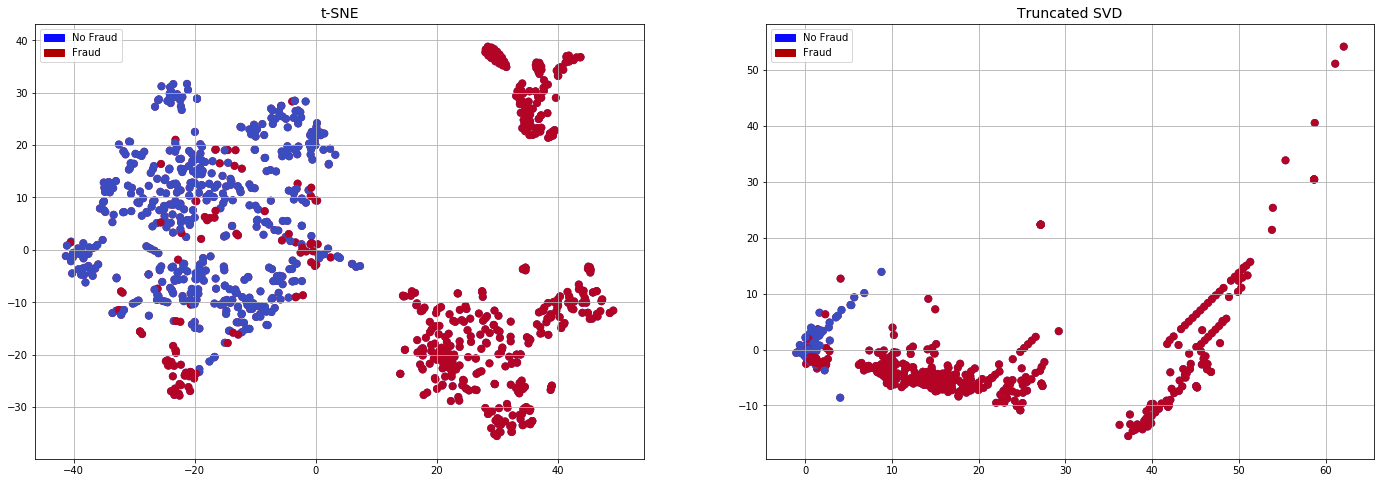

In [17]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))
blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')
ax1.scatter(X_reduced_tsne[:,0], 
            X_reduced_tsne[:,1], 
            c=(y == 0), 
            cmap='coolwarm', 
            label='No Fraud', 
            linewidths=2)
ax1.scatter(X_reduced_tsne[:,0],
            X_reduced_tsne[:,1],
            c=(y == 1),
            cmap='coolwarm',
            label='Fraud',
            linewidths=2)
ax1.set_title('t-SNE', fontsize=14)
ax1.grid()
ax1.legend(handles=[blue_patch, red_patch])
ax2.scatter(X_reduced_svd[:,0],
            X_reduced_svd[:,1],
            c=(y == 0),
            cmap='coolwarm',
            label='No Fraud',
            linewidths=2)
ax2.scatter(X_reduced_svd[:,0],
            X_reduced_svd[:,1],
            c=(y == 1),
            cmap='coolwarm',
            label='Fraud',
            linewidths=2)
ax2.set_title('Truncated SVD', fontsize=14)
ax2.legend(handles=[blue_patch, red_patch])
ax2.grid()

Now try four different classification methods: <br>
- Logistic Regression
- kNN
- Support vector classifier
- Decision tree

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [19]:
logistic_regression = LogisticRegression(solver='lbfgs')
logistic_regression.fit(X_train, y_train)
training_score = cross_val_score(logistic_regression, X_train, y_train, cv=5)
print(f'Logistic Regression training accuracy = {round(100*training_score.mean(), 2)}%')

neigh = KNeighborsClassifier()
neigh.fit(X_train, y_train)
training_score = cross_val_score(neigh, X_train, y_train, cv=5)
print(f'K Nearest Neighbours training accuracy = {round(100*training_score.mean(), 2)}%')

support_vector_clf = SVC(gamma='auto')
support_vector_clf.fit(X_train, y_train)
training_score = cross_val_score(support_vector_clf, X_train, y_train, cv=5)
print(f'Support vector classifier training accuracy = {round(100*training_score.mean(), 2)}%')

decision_tree_clf = DecisionTreeClassifier()
decision_tree_clf.fit(X_train, y_train)
training_score = cross_val_score(decision_tree_clf, X_train, y_train, cv=5)
print(f'Decision tree classifier training accuracy = {round(100*training_score.mean(), 2)}%')

Logistic Regression training accuracy = 94.92%
K Nearest Neighbours training accuracy = 94.67%
Support vector classifier training accuracy = 93.01%
Decision tree classifier training accuracy = 91.1%


Using Grid Search to optimise choice of parameters:

In [20]:
"""Params ranges have been narrowed down after several runs"""

log_reg_params = {"penalty": ['l1', 'l2'], 
                  'C': [0.5, 0.75, 1, 1.25]}
knears_params = {"n_neighbors": [2, 3, 4, 5, 6],
                 "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute']}
svc_params = {"C": [0.7, 0.75, 0.8, 0.85, 0.9],
              "kernel": ['rbf', 'poly', 'sigmoid', 'linear']}
tree_params = {"criterion": ["gini", "entropy"],
               "max_depth": [2, 3, 4, 5, 6],
               "min_samples_leaf": [7, 8, 9, 10, 11]}

grid_logistic_regression = GridSearchCV(LogisticRegression(), log_reg_params)
grid_logistic_regression.fit(X_train, y_train)
print(grid_logistic_regression.best_params_)
logistic_regression = grid_logistic_regression.best_estimator_
training_score = cross_val_score(logistic_regression, X_train, y_train, cv=5)
print(f'Logistic Regression training accuracy = {round(100*training_score.mean(), 2)}%')
print('-'*60)

grid_neigh = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_neigh.fit(X_train, y_train)
print(grid_neigh.best_params_)
neigh = grid_neigh.best_estimator_
training_score = cross_val_score(neigh, X_train, y_train, cv=5)
print(f'K Nearest Neighbours training accuracy = {round(100*training_score.mean(), 2)}%')
print('-'*60)

grid_support_vector_clf = GridSearchCV(SVC(gamma='auto'), svc_params)
grid_support_vector_clf.fit(X_train, y_train)
print(grid_support_vector_clf.best_params_)
support_vector_clf = grid_support_vector_clf.best_estimator_
training_score = cross_val_score(support_vector_clf, X_train, y_train, cv=5)
print(f'Support vector classifier training accuracy = {round(100*training_score.mean(), 2)}%')
print('-'*60)

grid_decision_tree_clf = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_decision_tree_clf.fit(X_train, y_train)
print(grid_decision_tree_clf.best_params_)
decision_tree_clf = grid_decision_tree_clf.best_estimator_
training_score = cross_val_score(decision_tree_clf, X_train, y_train, cv=5)
print(f'Decision tree classifier training accuracy = {round(100*training_score.mean(), 2)}%')
print('-'*60)

{'C': 0.75, 'penalty': 'l1'}
Logistic Regression training accuracy = 95.17%
------------------------------------------------------------
{'algorithm': 'auto', 'n_neighbors': 4}
K Nearest Neighbours training accuracy = 94.28%
------------------------------------------------------------
{'C': 0.7, 'kernel': 'linear'}
Support vector classifier training accuracy = 94.79%
------------------------------------------------------------
{'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 8}
Decision tree classifier training accuracy = 93.65%
------------------------------------------------------------


In [21]:
grid_logreg_pred = grid_logistic_regression.predict(X_test)
grid_neigh_pred = grid_neigh.predict(X_test)
grid_support_vec_pred = grid_support_vector_clf.predict(X_test)
decision_tree_pred = decision_tree_clf.predict(X_test)

grid_logreg_confusion = confusion_matrix(grid_logreg_pred, y_test)
grid_neigh_confusion = confusion_matrix(grid_neigh_pred, y_test)
grid_support_vec_confusion = confusion_matrix(grid_support_vec_pred, y_test)
decision_tree_confusion = confusion_matrix(decision_tree_pred, y_test)

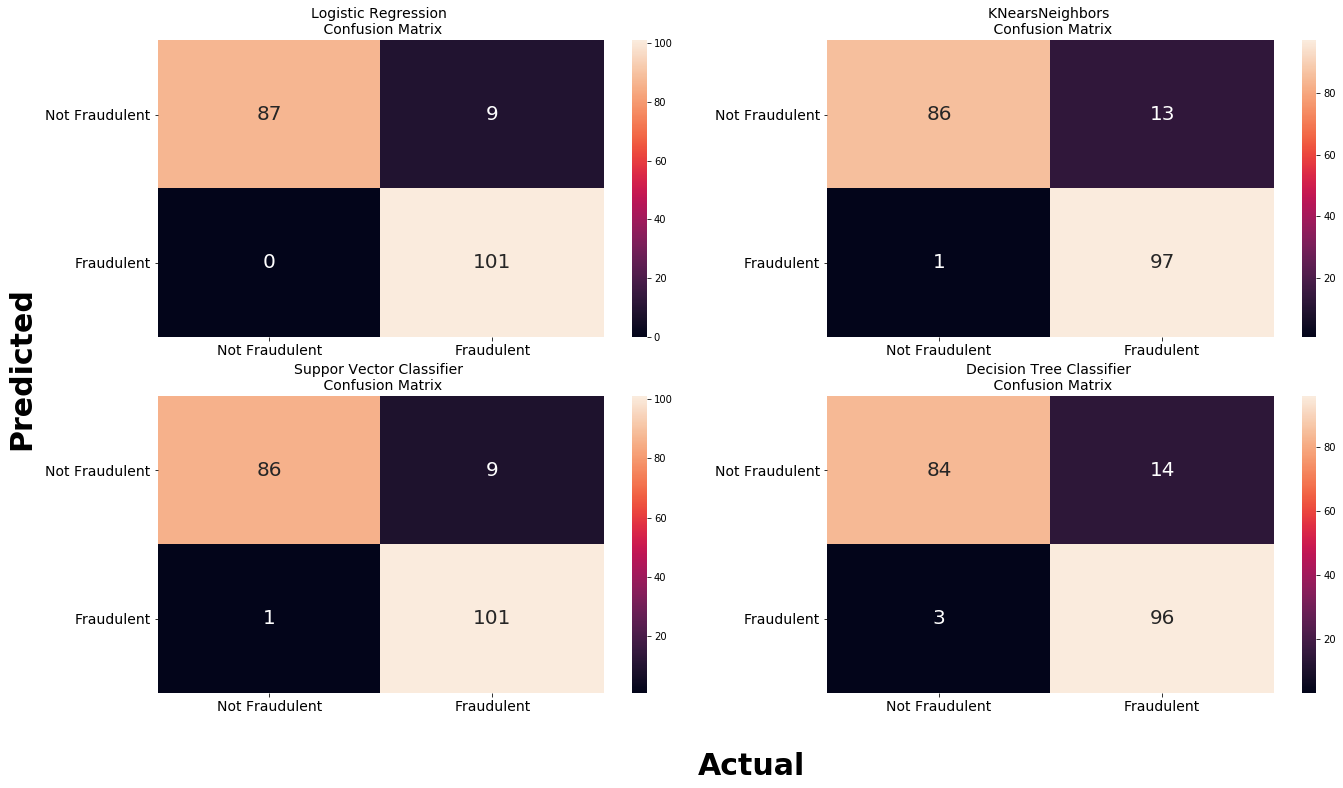

In [22]:
fig, ax = plt.subplots(2, 2, figsize=(22, 12))
annot_kws = {"fontsize": 20}
labels = ['Not Fraudulent', 'Fraudulent']

sns.heatmap(grid_logreg_confusion, ax=ax[0][0], annot=True, fmt='d', annot_kws=annot_kws)
ax[0, 0].set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax[0, 0].set_xticklabels(labels, fontsize=14, rotation=0)
ax[0, 0].set_yticklabels(labels, fontsize=14, rotation=360)

sns.heatmap(grid_neigh_confusion, ax=ax[0][1], annot=True, fmt='d', annot_kws=annot_kws)
ax[0][1].set_title("KNearsNeighbors \n Confusion Matrix", fontsize=14)
ax[0][1].set_xticklabels(labels, fontsize=14, rotation=0)
ax[0][1].set_yticklabels(labels, fontsize=14, rotation=360)

sns.heatmap(grid_support_vec_confusion, ax=ax[1][0], annot=True, fmt='d', annot_kws=annot_kws)
ax[1][0].set_title("Suppor Vector Classifier \n Confusion Matrix", fontsize=14)
ax[1][0].set_xticklabels(labels, fontsize=14, rotation=0)
ax[1][0].set_yticklabels(labels, fontsize=14, rotation=360)

sns.heatmap(decision_tree_confusion, ax=ax[1][1], annot=True, fmt='d', annot_kws=annot_kws)
ax[1][1].set_title("Decision Tree Classifier \n Confusion Matrix", fontsize=14)
ax[1][1].set_xticklabels(labels, fontsize=14, rotation=0)
ax[1][1].set_yticklabels(labels, fontsize=14, rotation=360)

fig.text(0.5, 0.03, 'Actual', ha='center', fontdict={'size': 30, 'weight': 'bold'})
fig.text(0.03, 0.5, 'Predicted', va='center', rotation='vertical', fontdict={'size': 30, 'weight': 'bold'})
plt.show()

In [23]:
print('Logistic Regression:')
print(classification_report(y_test, grid_logreg_pred))
print('-'*60)

print('KNears Neighbors:')
print(classification_report(y_test, grid_neigh_pred))
print('-'*60)

print('Support Vector Classifier:')
print(classification_report(y_test, grid_support_vec_pred))
print('-'*60)

print('Decision Tree Classifier:')
print(classification_report(y_test, decision_tree_pred))
print('-'*60)

Logistic Regression:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        87
           1       1.00      0.92      0.96       110

    accuracy                           0.95       197
   macro avg       0.95      0.96      0.95       197
weighted avg       0.96      0.95      0.95       197

------------------------------------------------------------
KNears Neighbors:
              precision    recall  f1-score   support

           0       0.87      0.99      0.92        87
           1       0.99      0.88      0.93       110

    accuracy                           0.93       197
   macro avg       0.93      0.94      0.93       197
weighted avg       0.94      0.93      0.93       197

------------------------------------------------------------
Support Vector Classifier:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95        87
           1       0.99      0.92      0.95      